# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Get street networks and other spatial data anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  - impute speeds/travel times and calculate shortest paths
  - attach and visualize elevation data and edge grades
  - download/model other infrastructure types
  - download points of interest data

In [1]:
import networkx as nx
import osmnx as ox

%matplotlib inline
ox.__version__

'1.1.2'

## Working with street networks

C:\Users\Cyrus\anaconda3\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


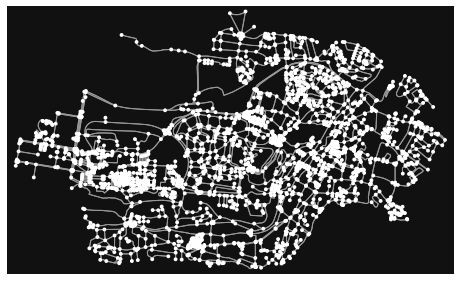

In [7]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place("Palaiseau, France", network_type="walk")
fig, ax = ox.plot_graph(G)

OSMnx geocodes the query "Piedmont, California, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples.

OSMnx models all networks as NetworkX `MultiDiGraph` objects. You can convert to:
  - undirected MultiGraphs
  - DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

In [8]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.utils_graph.get_digraph(G)

In [9]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
10046935,48.713036,2.252683,1,NaN,NaN,POINT (2.25268 48.71304)
29015901,48.721660,2.256550,3,NaN,NaN,POINT (2.25655 48.72166)
137572230,48.721153,2.251387,4,traffic_signals,NaN,POINT (2.25139 48.72115)
139182692,48.727467,2.229379,3,NaN,NaN,POINT (2.22938 48.72747)
139185773,48.727622,2.230365,3,NaN,NaN,POINT (2.23037 48.72762)


In [10]:
gdf_edges.head()

osmid  oneway   highway  \
u         v          key                                                      
10046935  4866917442 0                          331091844   False   service   
29015901  1630450206 0                            4587775   False  tertiary   
          537641666  0                            4587775   False  tertiary   
137572230 3465441558 0    [14312098, 223466636, 14312101]   False  tertiary   
          1383528030 0    [124266151, 42926718, 42926719]   False   service   

                           service access   length  \
u         v          key                             
10046935  4866917442 0    driveway     no   34.398   
29015901  1630450206 0         NaN    NaN   13.153   
          537641666  0         NaN    NaN   49.181   
137572230 3465441558 0         NaN    NaN  384.739   
          1383528030 0         NaN     no  494.470   

                                                                   geometry  \
u         v          key                                                      
10046935  4866917442 0    LINESTRING (2.25268 48.71304, 2.25265 48.71322...   
29015901  1630450206 0    LINESTRING (2.25655 48.72166, 2.25653 48.72169...   
          537641666  0    LINESTRING (2.25655 48.72166, 2.25655 48.72162...   
137572230 3465441558 0    LINESTRING (2.25139 48.72115, 2.25142 48.72121...   
          1383528030 0    LINESTRING (2.25139 48.72115, 2.25148 48.72113...   

                         lanes maxspeed    junction    ref  \
u         v          key                                     
10046935  4866917442 0     NaN      NaN         NaN    NaN   
29015901  1630450206 0       1       40  roundabout    NaN   
          537641666  0       1       40  roundabout    NaN   
137572230 3465441558 0     NaN       50         NaN  D 156   
          1383528030 0       2       50         NaN    NaN   

                                                                       name  \
u         v          key                                                      
10046935  4866917442 0                                                  NaN   
29015901  1630450206 0                                                  NaN   
          537641666  0                                                  NaN   
137572230 3465441558 0    [Avenue Raymond Aron, Boulevard de la Grande C...   
          1383528030 0                                                  NaN   

                         bridge tunnel width est_width  
u         v          key                                
10046935  4866917442 0      NaN    NaN   NaN       NaN  
29015901  1630450206 0      NaN    NaN   NaN       NaN  
          537641666  0      NaN    NaN   NaN       NaN  
137572230 3465441558 0      yes    NaN   NaN       NaN  
          1383528030 0      yes    NaN   NaN       NaN

You can create a graph from node/edge GeoDataFrames, as long as gdf_nodes is indexed by osmid and gdf_edges is multi-indexed by u, v, key (following normal MultiDiGraph structure). This allows you to load graph node/edge shapefiles or GeoPackage layers as GeoDataFrames then convert to a MultiDiGraph for graph analytics.

In [11]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

## Basic street network stats

In [12]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

12787799.88568341

In [13]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 2612,
 'm': 7016,
 'k_avg': 5.372128637059724,
 'edge_length_total': 416647.2880000002,
 'edge_length_avg': 59.38530330672751,
 'streets_per_node_avg': 2.7308575803981623,
 'streets_per_node_counts': {0: 0, 1: 517, 2: 0, 3: 1780, 4: 299, 5: 16},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.19793261868300152,
  2: 0.0,
  3: 0.6814701378254211,
  4: 0.11447166921898928,
  5: 0.006125574272588055},
 'intersection_count': 2095,
 'street_length_total': 208323.64399999983,
 'street_segment_count': 3508,
 'street_length_avg': 59.38530330672743,
 'circuity_avg': 1.0691440449632397,
 'self_loop_proportion': 0.0019954389965792475,
 'clean_intersection_count': 924,
 'node_density_km': 204.25718445314945,
 'intersection_density_km': 163.82802504952073,
 'edge_density_km': 32581.62402638611,
 'street_density_km': 16290.812013193035,
 'clean_intersection_density_km': 72.25636999797477}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [ ]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath="./data/mynetwork.gpkg")
ox.save_graphml(G, filepath="./data/mynetwork.graphml")

## Visualize street centrality

Here we plot the street network and color its edges (streets) by their relative closeness centrality.

In [14]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

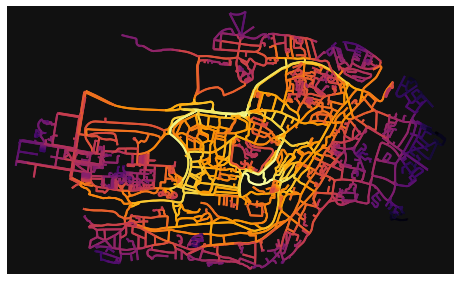

In [15]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Routing

In [ ]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [ ]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, X=-122.245846, Y=37.828903)
dest = ox.distance.nearest_nodes(G, X=-122.215006, Y=37.812303)

In [ ]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [ ]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
round(sum(edge_lengths))

In [ ]:
# how far is it between these two nodes as the crow flies?
# use OSMnx's vectorized great-circle distance (haversine) function
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle_vec(orig_y, orig_x, dest_y, dest_x))

You can add elevation attributes to your graph's nodes automatically with the `elevation` module, using either local raster files or the Google Maps Elevation API.

In [ ]:
# add elevation to nodes automatically, calculate edge grades, plot network
# you need a google elevation api key to run this cell!
try:
    from keys import google_elevation_api_key

    G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
    G = ox.elevation.add_edge_grades(G)
    nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
    fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")
except ImportError:
    print("You need a google_elevation_api_key to run this cell.")

Nodes are colored from lowest elevation (dark blue) to highest (bright yellow).

Example: create [elevation-based](12-node-elevations-edge-grades.ipynb) impedance functions to route around hills.

## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

In [ ]:
# you can make query an unambiguous dict to help the geocoder find it
place = {"city": "San Francisco", "state": "California", "country": "USA"}
G = ox.graph_from_place(place, network_type="drive", truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color="y", edge_linewidth=0.2)

In [ ]:
# you can get networks anywhere in the world
G = ox.graph_from_place("Sinalunga, Italy", network_type="all")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

In [ ]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609  # meters
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0)

Examples of [getting networks](01-overview-osmnx.ipynb) by coordinates, bounding box, or any custom polygon shape.

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

In [ ]:
# get NY subway rail network
G = ox.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

## Get any geospatial entities' geometries and attributes

Use the `geometries` module to download entities, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.geometries). For more usage examples of downloading geospatial objects from OSM, see [this notebook](16-download-osm-geospatial-entities.ipynb).

In [ ]:
# get all building footprints in some neighborhood
place = "Bunker Hill, Los Angeles, California"
tags = {"building": True}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

In [ ]:
fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

See the other notebooks for more examples of visualization with OSMnx.

In [ ]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park", "highway": "bus_stop"}
gdf = ox.geometries_from_place(place, tags)
gdf.shape